Nick Harris  
Fellowship.ai image segmentation challenge  
The project will build an FCN-8 model using layers and pre-trained weights from a VGG-16 model trained on ImageNet.   
The model will be trained to segment a facial portrait into background and person classes.

In [1]:
import numpy as np 
import pandas as pd #easy DF imports
import os #path handling
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns #good functionality on top of matplotlib
import cv2
import shutil
import tensorflow as tf 
from tensorflow import keras
import tarfile
import tempfile
from six.moves import urllib
from PIL import Image
import helper
from sklearn.metrics import jaccard_similarity_score
from glob import glob
from skimage import transform

In [2]:
#Importing annotations first to perform EDA in order to see general distribution of various attributes seen in these images. 
pathbase=r"C:\Users\nickh\fellowshipAI" #harcoded because notebook stored in git folder, images/annotations local
attr_path=r"Portrait-image-matting\celebaHQ\CelebAMask-HQ-attribute-anno.txt"
celeb_attr=pd.read_csv(os.sep.join([pathbase, attr_path]), sep=" +", header=1, engine='python')
attr_tidy=celeb_attr.melt(var_name='attribute') #data needs to be tidy for easy graphing with seaborn

In [3]:
print(celeb_attr.info())
#Just verifying there aren't null entries in attribute dataset

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 0.jpg to 29999.jpg
Data columns (total 40 columns):
5_o_Clock_Shadow       30000 non-null int64
Arched_Eyebrows        30000 non-null int64
Attractive             30000 non-null int64
Bags_Under_Eyes        30000 non-null int64
Bald                   30000 non-null int64
Bangs                  30000 non-null int64
Big_Lips               30000 non-null int64
Big_Nose               30000 non-null int64
Black_Hair             30000 non-null int64
Blond_Hair             30000 non-null int64
Blurry                 30000 non-null int64
Brown_Hair             30000 non-null int64
Bushy_Eyebrows         30000 non-null int64
Chubby                 30000 non-null int64
Double_Chin            30000 non-null int64
Eyeglasses             30000 non-null int64
Goatee                 30000 non-null int64
Gray_Hair              30000 non-null int64
Heavy_Makeup           30000 non-null int64
High_Cheekbones        30000 non-null int64
Male    

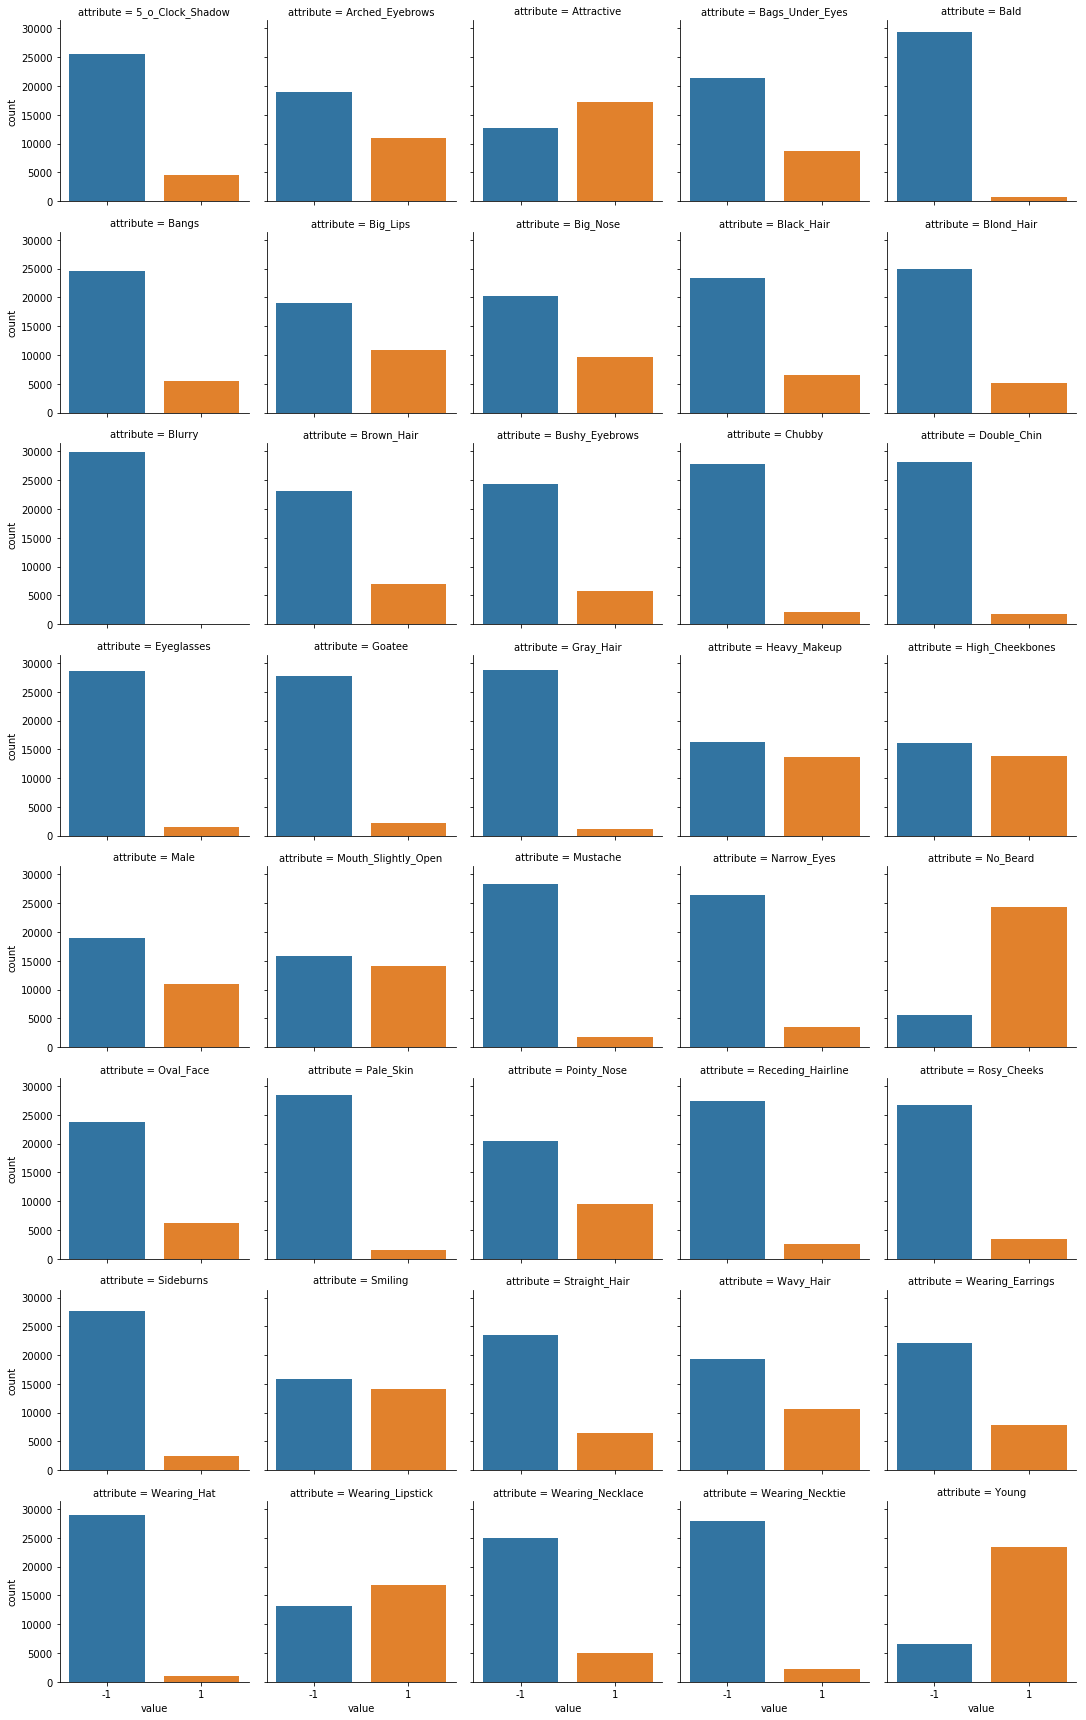

In [4]:
#Boxplots to visualize relative proportion of images that have each attribute
sns.catplot(data=attr_tidy, x='value', y=None, col='attribute', kind='count', col_wrap=5, height=3, aspect=1)

We can already see that a number of attributes are not going to be well represented in this set. This isn't suprising given that many of these attributes are expected to belong to only a smaller percentage of the population (sadly 50% of people don't sport mustaches). It does give us cases to scrutinize once we have a working model. Looking at a combination of proportional representation and how that attribute would effect an object's boundary, we can identify a few attributes that may perform poorly: wearing_hat, eyeglasses, mustache and double chin. There are some other attributes such as bald that have low representation, but given that baldnesss should make for more smooth, distinct boundary lines it likely wouldn't create problems in a segmentation model. 

Racial attributes aren't included in the dataset, but given that this data comes from a set of western celebrities, poor minority representation is likely. A quick manual scroll through the image set confirms this, with largely white subjects visible. This is a problem with most facial datasets I've come across, and it's well documented that this generally leads to worse performance working with BIPOC persons in images. It shouldn't show up heavily in test statistics since they're coming from the same dataset, but would be issue with real world application of the model.
   
  
The creators of the original CelebA dataset also created a subset of their dataset with pixel-wise annotations. We can use this dataset in order to fine-tune a model for person specific image matting. The dataset gives annotations in the form of image maps for each facial attribute, but I'm only concerned about person vs background. Each of these individual maps will need to be merged into one person vs background label for training/validation/testing

In [ ]:
tot_images = 30000 #total number of images in the HQ dataset
#list of all attributes mapped in the dataset. All of these will become a 1 for person in the mask.
labels = ['skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth', 'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']
source_folder = r"C:\Users\nickh\fellowshipAI\Portrait-image-matting\celebaHQ\CelebAMask-HQ-mask-anno" #annotations folder
dest_folder = r"C:\Users\nickh\fellowshipAI\Portrait-image-matting\celebaHQ\SegmentationClass"  #final mask folder
for k in range(tot_images):
    folder_num = k // 2000 #dataset split into 15 folders with each containing annotations for 2000 images split in numerical order
    mask = np.zeros((512, 512)) #dataset is already resized/cropped into 512x512 images. 
    for i, label in enumerate(labels):
        filename = os.path.join(source_folder, str(folder_num), str(k).rjust(5, '0') + '_' + label + '.png')
        if (os.path.exists(filename)):
            img_temp = cv2.imread(filename)
            img_temp = img_temp[:, :, 0]
            #labels any pixel in an attribute map as non-background. 
            mask[img_temp != 0] = (1) 

    filename_mask = os.path.join(dest_folder, str(k) + '.png')
    cv2.imwrite(filename_mask, mask)

We now have converted the individual attribute masks for each image into a single person vs background mask for each image. The original celeba dataset includes a list_eval partition, and the makers of the HQ dataset recommend using the same partition. The datasets are different sizes (nobody wants to manually annotate 200k images), so they've supplied a mapping file to allow the subset of images used for the HQ dataset to be used on the orginal test/eval/train partition. 

In [ ]:
#Source does not state relative proportions of train/test/val for HQ dataset
#Will validate we have reasonable proportions after separation
train_count = 0
test_count = 0
val_count = 0

#Source folders
img_source = r"celebaHQ\JPEGImages"
mask_source = r"celebaHQ\SegmentationClass"
#Training Dest. folders
img_dest_train = r"C:\Users\nickh\fellowshipAI\Portrait-image-matting\celebaHQ\splits\train_img"
mask_dest_train = r"C:\Users\nickh\fellowshipAI\Portrait-image-matting\celebaHQ\splits\train_img\label"
#Validation Dest. folders
img_dest_val = r"celebaHQ\splits\val_img"
mask_dest_val = r"celebaHQ\splits\val_img\label"
#Test Dest. folders
img_dest_test = r"celebaHQ\splits\test_img"
mask_dest_test = r"celebaHQ\splits\test_img\label"

image_mapping = pd.read_csv(r"celebaHQ\CelebA-HQ-to-CelebA-mapping.txt", delim_whitespace=True, header=None)

for i, x in enumerate(image_mapping.loc[:, 1]):
    if x < 162771:
        shutil.copy2(os.path.join(mask_source, str(i)+'.png'), os.path.join(mask_dest_train, str(val_count)+'.png'))
        shutil.copy2(os.path.join(img_source, str(i)+'.jpg'), os.path.join(img_dest_train, str(val_count)+'.jpg')) 
        train_count += 1  
        
    elif  x >= 182638:
        shutil.copy2(os.path.join(mask_source, str(i)+'.png'), os.path.join(mask_dest_test, str(val_count)+'.png'))
        shutil.copy2(os.path.join(img_source, str(i)+'.jpg'), os.path.join(img_dest_test, str(val_count)+'.jpg')) 
        test_count += 1 
        
    else:
        shutil.copy2(os.path.join(mask_source, str(i)+'.png'), os.path.join(mask_dest_val, str(val_count)+'.png'))
        shutil.copy2(os.path.join(img_source, str(i)+'.jpg'), os.path.join(img_dest_val, str(val_count)+'.jpg'))        
        val_count += 1
        

total_counts = train_count + test_count + val_count
print('training portion is ' + str(train_count/total_counts) + '   Counts are:' + str(train_count))
print('validation portion is ' + str(val_count/total_counts) + '   Counts are:' + str(val_count))
print('test portion is ' + str(test_count/total_counts) + '   Counts are:' + str(test_count))

The CelebA-HQ training/validation/test splits are set up for a roughly 80/10/10 split, which is reasonable and commonly used. With some basic EDA done and everything set up on our local environment, it's time to choose a model.   

The dataset with avilable mask annotations for training is also already cropped and resized to a fixed input (512x512). For the paper associated with the creation of this dataset, the backbone is an FCN-8 architecture[1]. I will create my own and train it. In order to reduce total training time, I will use pre-trained weights for VGG-16 taken from tensorflow stored models, trained on imagenet. 

In general, any FCN architecture would work for this task. The FCN-16 and FCN-32 architectures would have lower accuracy due to the large stride needed when upsampling directly from the last pool layer. In general, both FCN-16 and FCN-32 will generate too coarse of a map.

FCN-8 can be made using the first layers of a pre-trained VGG-16 model. We should see higher initial skill and a faster skill improvement using pre-trained weights from a VGG-16 model as the encoder. The models will have to diverge once the VGG-16 architecture gets to the fully connected layers. The pre-trained weights from the original VGG-16 model can still be used though, and should be extracted. I will build in tensorflow syntax rather than keras in order to get some experience on the backend that's covered with the Keras api.

In [3]:
#Model creation will start by taking layers from VGG-16
#There is already vgg16 model and pre-trained weights in my local working directory
def load_vgg_16(sess, vgg_model_path):
    model = tf.saved_model.loader.load(sess, export_dir = vgg_model_path, tags=['vgg16'])
    
    graph = tf.get_default_graph()
    image_in = graph.get_tensor_by_name('image_input:0')
    keep_per = graph.get_tensor_by_name('keep_prob:0')
    
    #3,4,7 are specifically needed as they are used to create skip-layers used in the upsampling process
    #L_7 is the last stage before this model deviates from VGG-16 architecture
    L_3 = graph.get_tensor_by_name('layer3_out:0')
    L_4 = graph.get_tensor_by_name('layer4_out:0')
    L_7 = graph.get_tensor_by_name('layer7_out:0')
    
    return image_in, keep_per, L_3, L_4, L_7

In [4]:
#Now we need to create the remaining layers.
#When creating this, I was envisioning only segmenting the foreground and background. Therefore, I would only use 2 classes.
def layer_create(L_3_out, L_4_out, L_7_out, num_classes = 2):

    # Would be the first dense layer in VGG architecture. 1x1 convolution for FCN-8. Happily, i get to name my first layer fcn8
    fcn_8 = tf.layers.conv2d(L_7_out, filters=num_classes, kernel_size=1, name="fcn_8")

    # Upsampling to match layer 4. FCN-8 skip architecture connects this layer to L_4
    fcn_9 = tf.layers.conv2d_transpose(fcn_8, filters=L_4_out.get_shape().as_list()[-1],
    kernel_size=4, strides=(2, 2), padding='SAME', name="fcn_9")

    #Connecting FCN_8 to layer 4 for skip connection
    fcn_9_skip = tf.add(fcn_9, L_4_out, name="fcn_9_plus_L_4_out")

    # Upsample
    fcn_10 = tf.layers.conv2d_transpose(fcn_9_skip, filters=L_3_out.get_shape().as_list()[-1],
    kernel_size=4, strides=(2, 2), padding='SAME', name="fcn_10")

    # Add skip connection
    fcn_10_skip = tf.add(fcn_10, L_3_out, name="fcn_10_plus_L_3_out")

    # Upsample again. 8x8 stride, hence the name
    fcn_11 = tf.layers.conv2d_transpose(fcn_10_skip, filters=num_classes,
    kernel_size=16, strides=(8, 8), padding='SAME', name="fcn_11")

    return fcn_11

We also need to choose an optimization and loss function. The loss function should come from the softmax function family, as they're well suited to mutually exclusive classification. The adams optimizer will be used for the training function. It incorporates a few important improvements over stochastic-GD. Namely, learning rates are applied per parameter ( similar to Adagrad) and  it incorporates recent gradient magnitudes similar to RMSProp.

In [5]:
#defining our optimizer and loss function
def optimize(fcn_last_layer, correct_label, learn_rate, num_classes = 2):
  
    # 4D tensors to 2D for calculations, row=pixel, column=class
    logits = tf.reshape(fcn_last_layer, (-1, num_classes), name="fcn_logits")
    correct_label_rs = tf.reshape(correct_label, (-1, num_classes))

    # Distance from actual labels from cross
    dist = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=correct_label_rs[:])
    loss_op = tf.reduce_mean(dist, name="fcn_loss")

    # Using adams optimizer as the optimization algorithm. It has some slight benefits over stochastic-GD. 
    #Incorporates learning rates applied per parameter ( similar to Adagrad) and recent gradient magnitures (like RMSProp)
    train_op = tf.train.AdamOptimizer(learning_rate=learn_rate).minimize(loss_op, name="fcn_train_op")

    return logits, train_op, loss_op

There are a few ways to check accuracy on the model. Pixel accuracy could be used, but it runs into issues with unevenly distributed classes. As an example, if your main class takes up only 1% of the pixels and your model predicts everything as the background, you've hit 99% accuracy. While our images are relatively balanced in terms of class portion, it's still a better practice to use mean Intercept over Union (m-IoU). m-IoU can still have issues when your all of your images do not contain all classes, but it's a fairly robust way of testing image segmentation problems.

In [6]:
#function to perform mean_iou on test set per run
def mean_iou(sess, logits, keep_prob, image_pl, data_folder, image_shape, num_classes):
    image_files = glob(os.path.join(data_folder, '*.jpg'))
    label_paths = glob(os.path.join(data_folder, 'label','*.png'))
    miou_store = []
    for i, image_file in enumerate(image_files):
        gt_image_file = label_paths[i]
        temp_gt = cv2.imread(gt_image_file)
        # Re-size to image_shape
        gt_image = scipy.misc.imresize(temp_gt, image_shape)
        gt_image = tf.reshape(correct_label, (-1, num_classes))
        image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
        # Run inference
        im_softmax = sess.run([tf.nn.softmax(logits)],{keep_prob: 1.0, image_pl: [image]})
        # Splice out second column (person), reshape output back to image_shape
        im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
        # If person softmax > 0.5, prediction is person
        segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
        segmentation = tf.reshape(segmentation, (-1, num_classes))

        #print out mIoU for this run on test set
        miou, _ = tf.compat.v1.metrics.mean_iou(tf.convert_to_tensor(gt_image), tf.convert_to_tensor(segmentation), 2)
        #output is in tensor form, need to revert to numpy array once it leaves this function
        miou_store.append(miou)
        
    return miou_store

In [7]:
#train function
def train_fcn(sess, epochs, batch_size, get_batches, train_op, cross_entropy_loss, 
              input_image,correct_label, keep_prob, learning_rate):
    keep_prob_value = 0.5
    learning_rate_value = 0.001
    for epoch in range(epochs):
        # Create function to get batches
        total_loss = 0
        for X_batch, gt_batch in get_batches(batch_size):

            loss, _ = sess.run([cross_entropy_loss, train_op],
            feed_dict={input_image: X_batch, correct_label: gt_batch,
            keep_prob: keep_prob_value, learning_rate:learning_rate_value})

            total_loss += loss;

        print("EPOCH {} ...".format(epoch + 1))
        print("Loss = {:.3f}".format(total_loss))

In [8]:
def run_training():
    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)

    # batches
    get_batches_fn = helper.gen_batch_function(training_dir, image_shape)
  
    with tf.Session() as session:
        
        # Returns the three layers, keep probability and input layer from the vgg architecture
        image_input, keep_prob, layer3, layer4, layer7 = load_vgg_16(session, vgg_model_path)

        # The resulting network architecture from adding a decoder on top of the given vgg model
        model_output = layer_create(layer3, layer4, layer7, num_classes)

        logits, train_op, cross_entropy_loss = optimize(model_output, correct_label, learning_rate, num_classes)
    
        # Initialize all variables
        session.run(tf.global_variables_initializer())
        session.run(tf.local_variables_initializer())

        print("Model build successful, starting training")

        # Train the neural network
        train_fcn(session, EPOCHS, BATCH_SIZE, get_batches_fn, 
             train_op, cross_entropy_loss, image_input,
             correct_label, keep_prob, learning_rate)

        # Run the model with the test images for visualization purposes/manual validation that model is working as intended
        helper.save_inference_samples(runs_dir, data_dir, session, image_shape, logits, keep_prob, image_input)
        
        #Calculate mean IoU for this model on test set
        m_iou = mean_iou(session, logits, keep_prob, image_input, test_path, image_shape, num_classes)
        session.run(tf.global_variables_initializer())
        session.run(tf.local_variables_initializer())
        mean_iou=[]
        for i in m_iou:
            mean_iou.append((i.eval())
        print(mean_iou.mean)
       
        #saving model
        saved_model = tf.train.Saver()
        #unique modelname for keeping track of saved models by tuning param
        modelname= ('fcn8-' + str(EPOCHS) + 'epochs-' + str(BATCH_SIZE) + 'batch-' + (str(DROPOUT)[-2:]) + 'dropout')
        saved_model.save(session, modelname)

In [9]:
#Tuning parameters
num_classes = 2
#helper function resizes. Images are 1024x 1024. Maps are 512x 512. 
#Dropping to 128x 128 for speed due to unfortunate circumstances forcing local training on a laptop.
#Training on small subset of dataset due to lack of gpu/access to kaggle
image_shape = (128, 128)
EPOCHS = 1
BATCH_SIZE = 4
DROPOUT = 0.95


#Directory Paths
data_dir = r"C:\Users\nickh\fellowshipAI\Portrait-image-matting\celebaHQ"
runs_dir = './runs'
training_dir ='./celebaHQ/splits/train_small'
vgg_model_path = r"C:\Users\nickh\fellowshipAI\Portrait-image-matting\celebaHQ\splits\vgg"
test_path = r"C:\Users\nickh\fellowshipAI\Portrait-image-matting\celebaHQ\splits\test_small"

#initialize tensors
correct_label = tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], num_classes], name='label_pl')
learning_rate = tf.placeholder(tf.float32, name='learnrate_pl')
keep_prob = tf.placeholder(tf.float32, name='keep_prob_pl')
image_pl = tf.placeholder(tf.float32, name='image_pl')
m_iou = tf.placeholder(tf.float32)

After a model is trained, it will be applied in two ways. First, I'll create overlay images over the result to show the matting. Second, the mean IoU will also be calculated. 

In [10]:
#Repurposed helper file to download model model, batch generator functions
#will run on multiple sets of tuning parameters, with each model exported by name generator at end of run_training fcn
%run helper.py
run_training()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Users\nickh\fellowshipAI\Portrait-image-matting\celebaHQ\splits\vgg\variables\variables
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Model build successful, starting training
EPOCH 1 ...
Loss = 152.623
Training Finished. Saving test images to: ./runs\1595307073.4412417


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


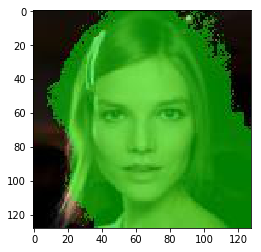

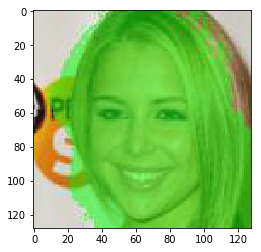

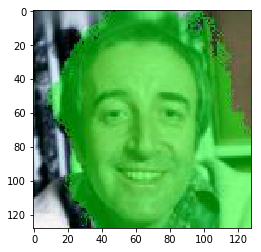

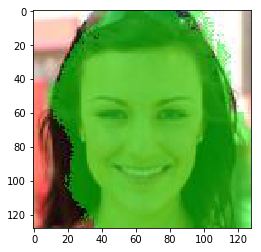

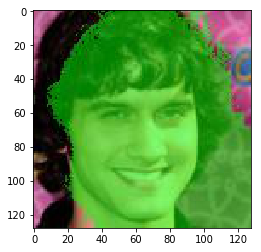

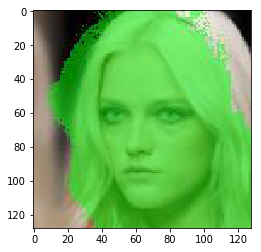

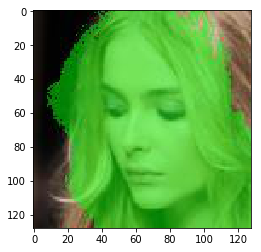

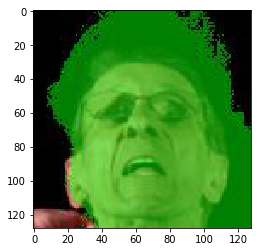

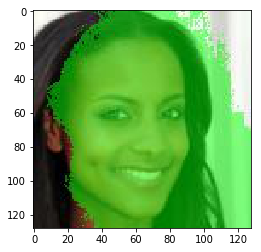

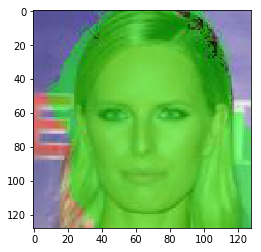

In [16]:
##Show output. Only 10 images to be shown
test_img_folder = r"C:\Users\nickh\fellowshipAI\Portrait-image-matting\runs\1595220858.6682315"
test_image_files = glob(os.path.join(test_img_folder, '*.jpg'))
f = plt.figure()
for img_path in test_image_files:
    image_temp = cv2.imread(img_path)
    image = image_temp[:, :, ::-1] #Without converting between RGB/BGR, cv2 will display with strong blue hue
    f = plt.imshow(image)
    plt.show()


## Conclusion 

A few different iterations of the tuning parameters were tested. Batch size was left constant, as anything above 4 ran into memory errors and I didn't want to reduce image dimensions further due to detail loss. Dropout ranges from 0.25 to 0.9. Number of epochs trained ranged from 3 (for unlikely to work settings, such as 0.9 dropout) to 30. The best results were obtained using a standard dropout. Lower than normal dropouts also performed very well, likely due to the limited dataset size. Dropout is generally used to reduce overfitting, and the very small dataset size used (<300 images in training set) meant that the model was very prone to overfitting. In this case, the longer training times caused by high dropout rate were well worth it. Learning rate was also tested at 0.1, 0.01 and 0.001, with the lowest learning rate appearing to show the lowest loss after 10 epochs. Visually, the model struggles with both instances where the subject isn't directly facing the camera and with hair. Orientation is likely an issue of the model being trained on a dataset largely comprised of images looking directly at the camera. Hair poses a problem due to both fine details and frequent color boundaries.    

My model hit a minimum loss of 17.195 from softmax cross entropy using the following parameters:   
learning rate:0.001   
epochs:30   
Batch Size: 4   
Dropout: 0.5   

Currently, the automatic mIoU function is not working in this script. It will be fixed in the next commit. Current SoTA for mIoU image segmentation on portraits is around 0.98 using the architecture and feature engineering used by Shen et. al for their automatic segmentation [1]. In the same paper, an FCN-8 with minimual tuning had results ranging from 0.77 to 0.85. Although my model did not hit that benchmark, it is likely that the mIoU could be increased to those levels with a few simple changes. If implemented in an cloud GPU system, we'd be able to train on much more larger dataset. With ~24000 images available in my training set and a higher resolution of 512x512, it is likely we'd be able to come close to current benchmarks.   

When remaking this problem, I would likely use a more complex architecture. A pre-trained version of DeepLab v3+ with fine-tuning performed on only the top layers of the model would be able to easily beat the mIoU obtained by this FCN-8, regardless of how much I increase the training set or resolution. There are also some interesting opportunities for feature engineering given the type of images seen in this set. With self portrait images(selfies), relative position to facial center is an important factor. Using a facial feature detector on image preprocessing combined with giving each pixel a normalized difference from facial center would be a good way to capture that information, though it would remove the possiblity of doing incremental training and require full model fine-tuning. 

# References  

[1]Xiaoyong Shen, Aaron Hertzmann, Jiaya Jia, Sylvain Paris, Brian Price, Eli Shechtman, and Ian Sachs. 2016. Automatic portrait segmentation for image stylization. In Proceedings of the 37th Annual Conference of the European Association for Computer Graphics (EG ’16). Eurographics Association, Goslar, DEU, 93–102.